In [20]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, original_name, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title(original_name)
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

(512, 512)
int16


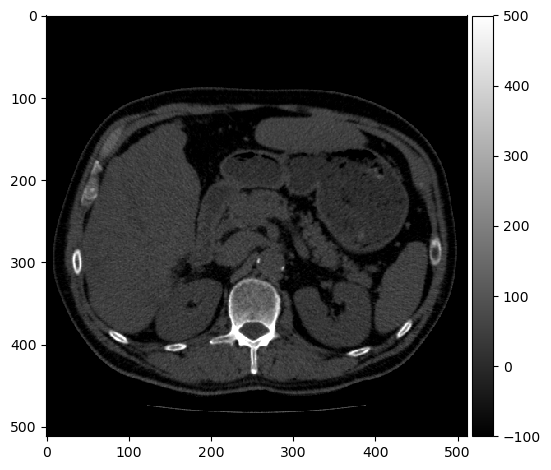

In [4]:
# Open the DICOM file
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

# Show the image
io.imshow(img, cmap="gray", vmin=-200, vmax=500)
io.show()

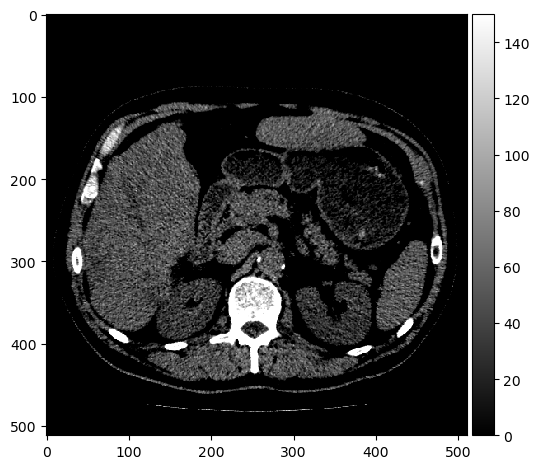

In [5]:
# Visualization of the spleen
spleen = img.copy()

# Show the image
io.imshow(spleen, cmap="gray", vmin=0, vmax=150)

In [7]:
# Value of the pixels in the spleen
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

# Average and standard deviation of the spleen
print("Average: ", np.mean(spleen_values))
print("Standard deviation: ", np.std(spleen_values))

Average:  49.48026905829597
Standard deviation:  14.9970794143059


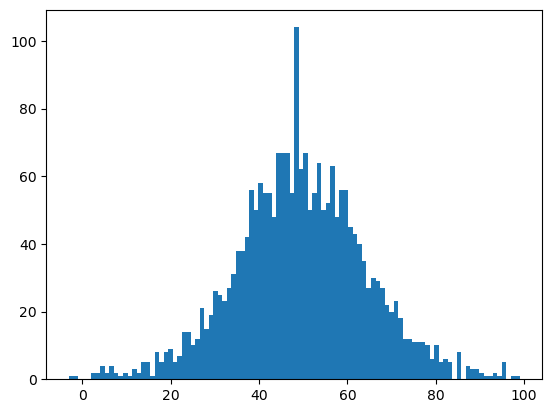

In [8]:
# Histogram of the spleen
plt.hist(spleen_values, bins=100)
plt.show()

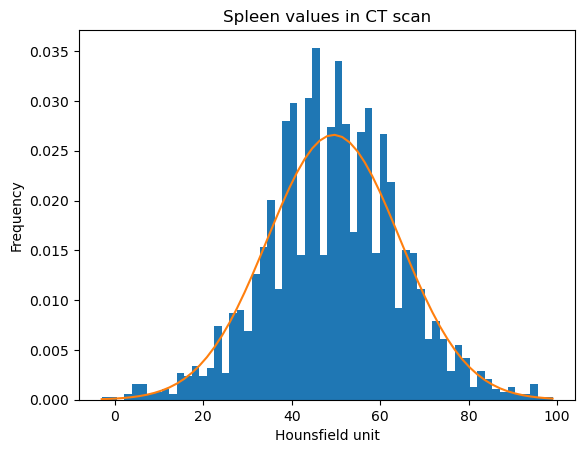

In [9]:
# Compare the histogram of the spleen with a normal distribution
# Fit a normal distribution to the data:
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

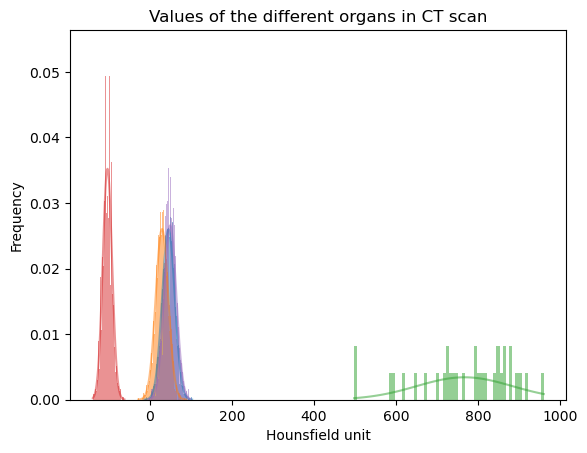

In [15]:
n, bins, patches = plt.hist(liver_values, 60, density=1, alpha=0.5)
pdf_liver = norm.pdf(bins, nu_liver, std_liver)
plt.plot(bins, pdf_liver, color=patches[0].get_facecolor())

n, bins, patches = plt.hist(kidney_values, 60, density=1, alpha=0.5)
pdf_kidney = norm.pdf(bins, nu_kidney, std_kidney)
plt.plot(bins, pdf_kidney, color=patches[0].get_facecolor())

n, bins, patches = plt.hist(bone_values, 60, density=1, alpha=0.5)
pdf_bone = norm.pdf(bins, nu_bone, std_bone)
plt.plot(bins, pdf_bone, color=patches[0].get_facecolor())

n, bins, patches = plt.hist(fat_values, 60, density=1, alpha=0.5)
pdf_fat = norm.pdf(bins, nu_fat, std_fat)
plt.plot(bins, pdf_fat, color=patches[0].get_facecolor())

n, bins, patches = plt.hist(spleen_values, 60, density=1, alpha=0.5)
pdf_spleen = norm.pdf(bins, nu_spleen, std_spleen)
plt.plot(bins, pdf_spleen, color=patches[0].get_facecolor())

plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Values of the different organs in CT scan')
plt.show()

c:\Users\Alejandro\anaconda3\envs\course02502\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


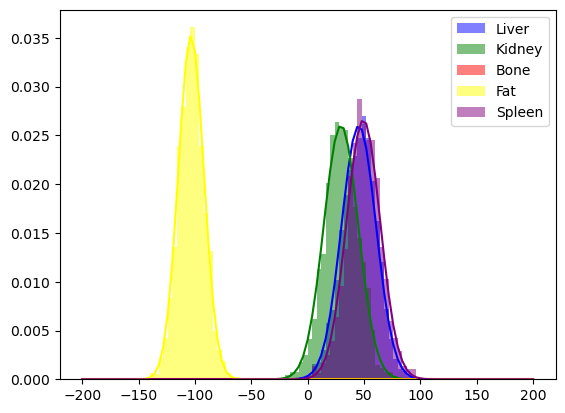

In [18]:
# Show the normal distribution of the different organs in the same plot between two values of Hounsfield units
lower = -200
upper = 200

n, bins, patches = plt.hist(liver_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Liver', color='blue')
pdf_liver = norm.pdf(bins, nu_liver, std_liver)
plt.plot(bins, pdf_liver, color='blue')

n, bins, patches = plt.hist(kidney_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Kidney', color='green')
pdf_kidney = norm.pdf(bins, nu_kidney, std_kidney)
plt.plot(bins, pdf_kidney, color='green')

n, bins, patches = plt.hist(bone_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Bone', color='red')
pdf_bone = norm.pdf(bins, nu_bone, std_bone)
plt.plot(bins, pdf_bone, color='red')

n, bins, patches = plt.hist(fat_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Fat', color='yellow')
pdf_fat = norm.pdf(bins, nu_fat, std_fat)
plt.plot(bins, pdf_fat, color='yellow')

n, bins, patches = plt.hist(spleen_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Spleen', color='purple')
pdf_spleen = norm.pdf(bins, nu_spleen, std_spleen)
plt.plot(bins, pdf_spleen, color='purple')

plt.legend(loc='upper right')
plt.show()

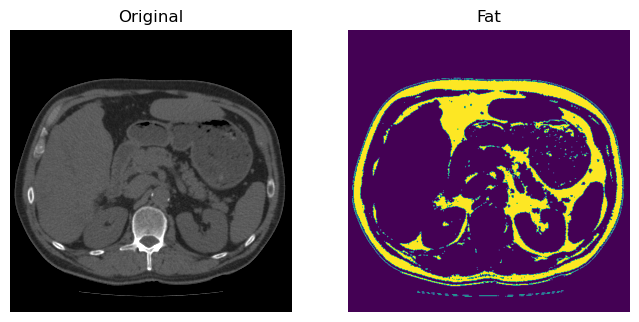

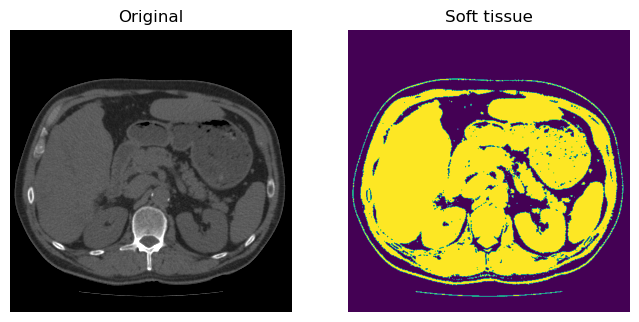

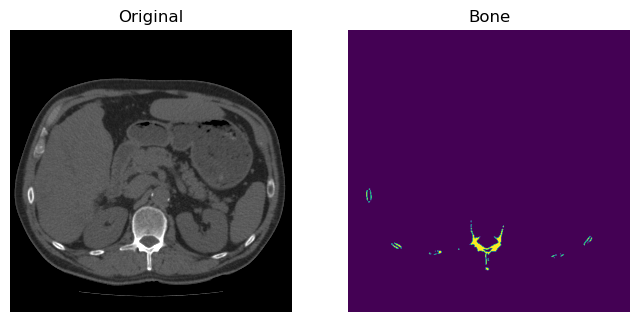

In [23]:
# Minimun distance pixel classification

# Soft tissue class: liver, kidney, spleen
# Bone class: bone
# Fat class: fat
# Background class: background

# Soft tissue class: combination of the pixels of the liver, kidney and spleen
soft_tissue = np.concatenate((liver_values, kidney_values, spleen_values))

# Bone class: bone
bone = bone_values

# Fat class: fat
fat = fat_values

# Background class: background
background = img[img < -200]

# Thresholds: average of the different classes
nu_soft_tissue = np.mean(soft_tissue)
nu_bone = np.mean(bone)
nu_fat = np.mean(fat)
nu_background = np.mean(background)

# Thresholds between classes: average of the different classes
t_background_fat = -200
t_fat_soft = (nu_fat + nu_soft_tissue) / 2
t_soft_bone = (nu_soft_tissue + nu_bone) / 2

# Get binary images
fat_img = (img > t_background_fat) & (img < t_fat_soft)
soft_tissue_img = (img > t_fat_soft) & (img < t_soft_bone)
bone_img = img > t_soft_bone

# Show the images
show_comparison(img, fat_img, "Original", "Fat")
show_comparison(img, soft_tissue_img, "Original", "Soft tissue")
show_comparison(img, bone_img, "Original", "Bone")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


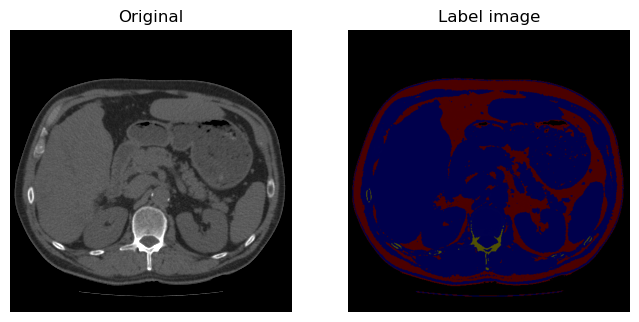

In [24]:
# Label image
label_img = fat_img * 1 + soft_tissue_img * 2 + bone_img * 3
img_label_overlay = label2rgb(label_img, image=img)

# Show comparison
show_comparison(img, img_label_overlay, "Original", "Label image")

c:\Users\Alejandro\anaconda3\envs\course02502\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


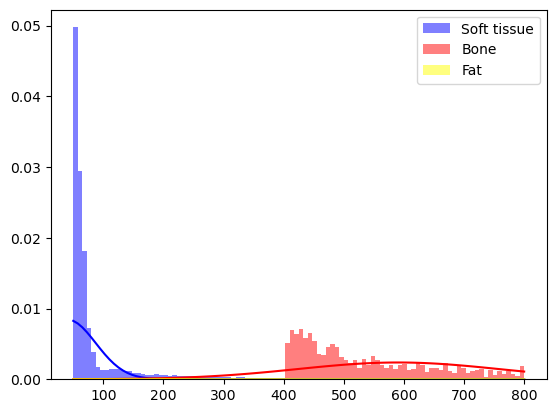

In [30]:
# Get parameters of the different classes
soft_tissue_values = img[soft_tissue_img]
bone_values = img[bone_img]
fat_values = img[fat_img]

# Average and standard deviation of the different classes
nu_soft_tissue = np.mean(soft_tissue_values)
std_soft_tissue = np.std(soft_tissue_values)

nu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

nu_fat = np.mean(fat_values)
std_fat = np.std(fat_values)

# Show the normal distribution of the different classes in the same plot between two values of Hounsfield units
lower = 50
upper = 800

n, bins, patches = plt.hist(soft_tissue_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Soft tissue', color='blue')
pdf_soft_tissue = norm.pdf(bins, nu_soft_tissue, std_soft_tissue)
plt.plot(bins, pdf_soft_tissue, color='blue')

n, bins, patches = plt.hist(bone_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Bone', color='red')
pdf_bone = norm.pdf(bins, nu_bone, std_bone)
plt.plot(bins, pdf_bone, color='red')

n, bins, patches = plt.hist(fat_values, bins=100, range=[lower, upper], density=1, alpha=0.5, label='Fat', color='yellow')
pdf_fat = norm.pdf(bins, nu_fat, std_fat)
plt.plot(bins, pdf_fat, color='yellow')

plt.legend(loc='upper right')
plt.show()

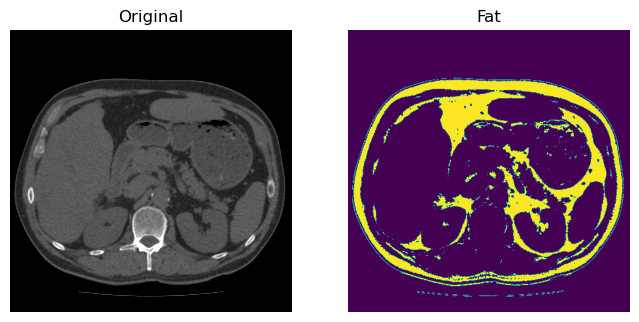

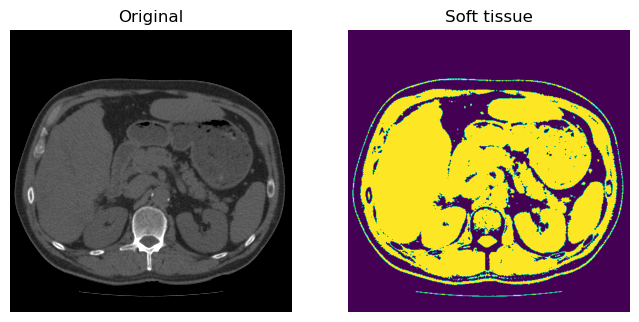

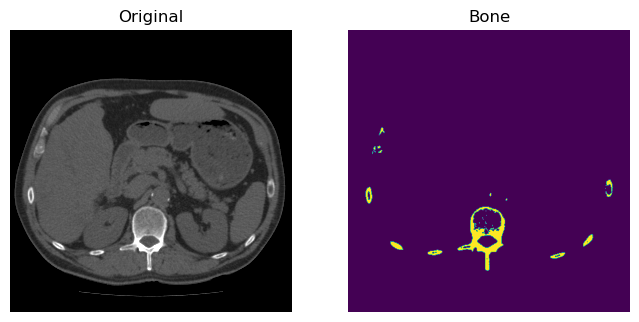

c:\Users\Alejandro\anaconda3\envs\course02502\lib\site-packages\skimage\color\colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


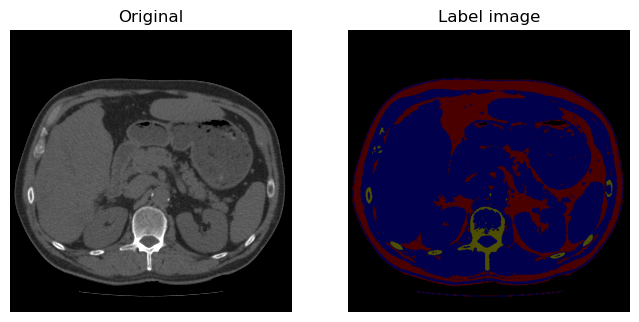

In [32]:
# Manual thesholding (intersection of the normal distributions)
t_background_fat = -200
t_fat_soft = -40
t_soft_bone = 175

# Get binary images
fat_img = (img > t_background_fat) & (img < t_fat_soft)
soft_tissue_img = (img > t_fat_soft) & (img < t_soft_bone)
bone_img = img > t_soft_bone

# Show the images
show_comparison(img, fat_img, "Original", "Fat")
show_comparison(img, soft_tissue_img, "Original", "Soft tissue")
show_comparison(img, bone_img, "Original", "Bone")

# Label image
label_img = fat_img * 1 + soft_tissue_img * 2 + bone_img * 3
img_label_overlay = label2rgb(label_img, image=img)
show_comparison(img, img_label_overlay, "Original", "Label image")
